# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [1]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [3]:
portfolio.head(10)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [170]:
transcript[transcript['person'] == '78afa995795e4d85b5d9ceeca43f5fef'].sort_values(['person', 'time'], ascending=True)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
15561,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},6
47582,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.89},132
47583,78afa995795e4d85b5d9ceeca43f5fef,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,132
49502,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 17.78},144
53176,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168
85291,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},216
87134,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.67},222
92104,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 29.72},240
141566,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 23.93},378


In [5]:
def clean_portfolio(portfolio):
    '''
    Clean the portfolio dataset:
    - transform the "duration" column to hours
    - one-hot-enconde both channels and offer_type columns
    - rename the "id" column to "offer_id"
    
    INPUT:
    - the original portfolio dataset
    
    OUTPUT:
    - the cleaned portfolio dataset (portfolio_clean) 
    
    '''
    #create a copy
    portfolio_clean = portfolio.copy()
    
    portfolio_clean['offer_id2'] = np.where((portfolio_clean['offer_type'] == 'bogo'), 'Bogo', 
                              np.where((portfolio_clean['offer_type'] == 'discount'), 'Disc', 'Info'))

    portfolio_clean['offer_id2'] = portfolio_clean['offer_type'].map(str) + '-' + portfolio_clean['difficulty'].map(str) + '-' + portfolio_clean['duration'].map(str)
        
    #transform the "duration" column into hours
    portfolio_clean['duration'] = portfolio_clean['duration']*24
    
    #rename "id" column
    portfolio_clean = portfolio_clean.rename(columns={'id': 'offer_id'})

    #one-hot-encode the "channels" column
    portfolio_clean = portfolio_clean.drop('channels', axis = 1).join(portfolio_clean.channels.str.join('|').str.get_dummies())

    #one-hot-enconde the "offer_type" column
    offers_type = pd.get_dummies(portfolio_clean['offer_type'])

    #drop the old "offer_type" column and join dummies
    #portfolio_clean = portfolio_clean.drop('offer_type', axis = 1).join(offers_type)
    portfolio_clean = portfolio_clean.join(offers_type)
    
    return portfolio_clean
    

In [6]:
def clean_profile(profile):
    '''
    Clean the profile dataset:
    - change de dtype for the "became_member_on" to datetime
    - one-hot-enconde the "gender" column
    - rename the "id" column to "user_id"

    INPUT:
    - the original profile dataset
    
    OUTPUT:
    - the cleaned profile dataset (profile_clean) 
    
    '''
    #create a copy
    profile_clean = profile.copy()

    #change dtype on the "became_member_on" column to datetime
    profile_clean['became_member_on'] = pd.to_datetime(profile_clean['became_member_on'].astype(str), format='%Y%m%d')

    #one-hot-enconde the "gender" column
    genders = pd.get_dummies(profile_clean['gender'])
    
    #drop the "gender" column and join dummies
    #profile_clean = profile_clean.drop('gender', axis = 1).join(genders)
    profile_clean = profile_clean.join(genders)

    #rename the "id" column to "user_id"
    profile_clean = profile_clean.rename(columns={'id': 'user_id'})
    
    return profile_clean
    

In [7]:
def clean_transcript(transcript):
    '''
    Clean the transcript dataset:
    - normalize the "value" column
    - rename "person", "offer id" and "offer_id" columns
    - consolidate all offers ids into one column
    - drop the unnecessary columns 
    - drop the "reward" column --> it will be replaced after the final merge
    
    INPUT:
    - the original profile dataset
    
    OUTPUT:
    - the cleaned profile dataset
    
    '''
    #create a copy
    transcript_clean = transcript.copy()
    
    #normalizing dict row into columns
    transcript_clean = transcript_clean.join(pd.json_normalize(transcript_clean.value))  

    #rename columns
    transcript_clean = transcript_clean.rename(columns={'person': 'user_id',
                                                        'offer id': 'offer_id_received',
                                                        'offer_id': 'offer_id_completed'
                                                       }
                                              )
    #get the offer_id data from both columns
    transcript_clean['offer_id'] = np.where(transcript_clean['offer_id_received'].notna() == True,
                                            transcript_clean['offer_id_received'],
                                            transcript_clean['offer_id_completed']
                                           )
    
    #drop columns
    transcript_clean = transcript_clean.drop(columns=['value',
                                                      'reward',
                                                      'offer_id_received',
                                                      'offer_id_completed'],
                                             axis = 1
                                            )
    
    #one-hot-enconde the "event" column
    events = pd.get_dummies(transcript_clean['event'])

    #drop the "event" column and join dummies
    #transcript_clean = transcript_clean.drop('event', axis = 1).join(events)
    transcript_clean = transcript_clean.join(events)
    
    return transcript_clean


In [8]:
portfolio_df = clean_portfolio(portfolio)
transcript_df = clean_transcript(transcript)
profile_df = clean_profile(profile)

In [9]:
def final_merge(portfolio_df, transcript_df, profile_df):
    '''
    Merge all cleaned datasets into one
    
    INPUT:
    portfolio_df
    transcript_df
    profile_df
    
    OUTPUT:
    df
    
    '''
    
    #merge transcript and profile
    df = transcript_df.merge(profile_df, how='left', on='user_id')
    
    #merge transcript and portfolio
    df = df.merge(portfolio_df, how='left', on='offer_id')
       
    #sort dataframe by user_id and offer_id
    df = df.sort_values(['user_id', 'offer_id'], ascending=False)
    
    #drop all nan values
    df = df[df['income'].notna()]
    
    #drop old offer_id column and replace it
    df = df.drop(columns=['offer_id'])
    df = df.rename(columns={'offer_id2': 'offer_id'})
    
    return df
    

In [10]:
portfolio_df.sort_values(['offer_type', 'difficulty'], ascending=False).reset_index().drop('index', axis=1).head(10)

,reward,difficulty,duration,offer_type,offer_id,offer_id2,email,mobile,social,web,bogo,discount,informational
0,0,0,96,informational,3f207df678b143eea3cee63160fa8bed,informational-0-4,1,1,0,1,0,0,1
1,0,0,72,informational,5a8bc65990b245e5a138643cd4eb9837,informational-0-3,1,1,1,0,0,0,1
2,5,20,240,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount-20-10,1,0,0,1,0,1,0
3,2,10,240,discount,fafdcd668e3743c1bb461111dcafc2a4,discount-10-10,1,1,1,1,0,1,0
4,2,10,168,discount,2906b810c7d4411798c6938adc9daaa5,discount-10-7,1,1,0,1,0,1,0
5,3,7,168,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,discount-7-7,1,1,1,1,0,1,0
6,10,10,168,bogo,ae264e3637204a6fb9bb56bc8210ddfd,bogo-10-7,1,1,1,0,1,0,0
7,10,10,120,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo-10-5,1,1,1,1,1,0,0
8,5,5,168,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo-5-7,1,1,0,1,1,0,0
9,5,5,120,bogo,f19421c1d4aa40978ebb69ca19b0e20d,bogo-5-5,1,1,1,1,1,0,0


In [11]:
transcript_df.head()

,user_id,event,time,amount,offer_id,offer completed,offer received,offer viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,0,1,0,0


In [12]:
profile_df.head()

,gender,age,user_id,became_member_on,income,F,M,O
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,0,0,0
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1,0,0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,0,0,0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,1,0,0
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,0,0,0


In [13]:
df = final_merge(portfolio_df, transcript_df, profile_df)

In [14]:
df[df['user_id'] == '6cf884a6c5ae4b2daccb6d3108028fef']

,user_id,event,time,amount,offer completed,offer received,offer viewed,transaction,gender,age,...,duration,offer_type,offer_id,email,mobile,social,web,bogo,discount,informational
112788,6cf884a6c5ae4b2daccb6d3108028fef,offer received,336,NaN,0,1,0,0,F,58,...,168.0,bogo,bogo-10-7,1.0,1.0,1.0,0.0,1.0,0.0,0.0
124113,6cf884a6c5ae4b2daccb6d3108028fef,offer viewed,336,NaN,0,0,1,0,F,58,...,168.0,bogo,bogo-10-7,1.0,1.0,1.0,0.0,1.0,0.0,0.0
130588,6cf884a6c5ae4b2daccb6d3108028fef,offer completed,348,NaN,1,0,0,0,F,58,...,168.0,bogo,bogo-10-7,1.0,1.0,1.0,0.0,1.0,0.0,0.0
1976,6cf884a6c5ae4b2daccb6d3108028fef,offer received,0,NaN,0,1,0,0,F,58,...,168.0,bogo,bogo-5-7,1.0,1.0,0.0,1.0,1.0,0.0,0.0
247062,6cf884a6c5ae4b2daccb6d3108028fef,offer received,576,NaN,0,1,0,0,F,58,...,72.0,informational,informational-0-3,1.0,1.0,1.0,0.0,0.0,0.0,1.0
304501,6cf884a6c5ae4b2daccb6d3108028fef,offer viewed,708,NaN,0,0,1,0,F,58,...,72.0,informational,informational-0-3,1.0,1.0,1.0,0.0,0.0,0.0,1.0
55173,6cf884a6c5ae4b2daccb6d3108028fef,offer received,168,NaN,0,1,0,0,F,58,...,96.0,informational,informational-0-4,1.0,1.0,0.0,1.0,0.0,0.0,1.0
77568,6cf884a6c5ae4b2daccb6d3108028fef,offer viewed,192,NaN,0,0,1,0,F,58,...,96.0,informational,informational-0-4,1.0,1.0,0.0,1.0,0.0,0.0,1.0
152584,6cf884a6c5ae4b2daccb6d3108028fef,offer received,408,NaN,0,1,0,0,F,58,...,168.0,discount,discount-7-7,1.0,1.0,1.0,1.0,0.0,1.0,0.0
187430,6cf884a6c5ae4b2daccb6d3108028fef,offer completed,456,NaN,1,0,0,0,F,58,...,168.0,discount,discount-7-7,1.0,1.0,1.0,1.0,0.0,1.0,0.0


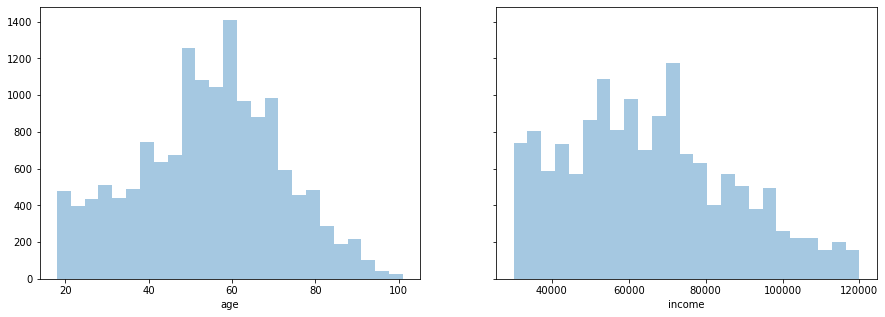

In [15]:
#users age and income
fig, ax = plt.subplots(1,2, sharey=True)

fig.set_size_inches(15,5)

#plot income histogram
income_hist = df.groupby(['user_id'])['age'].mean()
sns.distplot(income_hist, ax=ax[0], kde=False, bins=25);

#plot income histogram
income_hist = df.groupby(['user_id'])['income'].mean()
sns.distplot(income_hist, ax=ax[1], kde=False, bins=25);

<AxesSubplot:xlabel='income', ylabel='Density'>

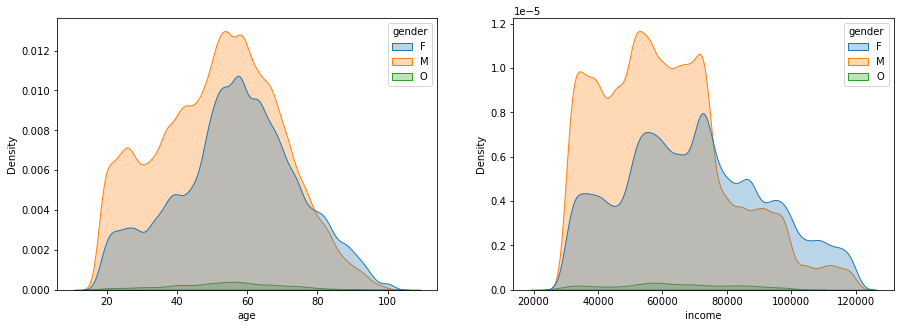

In [16]:
#age and income distribuction by gender
fig, ax = plt.subplots(1,2)

fig.set_size_inches(15,5)

sns.kdeplot(data=df, x='age', hue='gender', fill=True, ax=ax[0], alpha=0.3)
sns.kdeplot(data=df, x='income', hue='gender', fill=True, ax=ax[1], alpha=0.3)

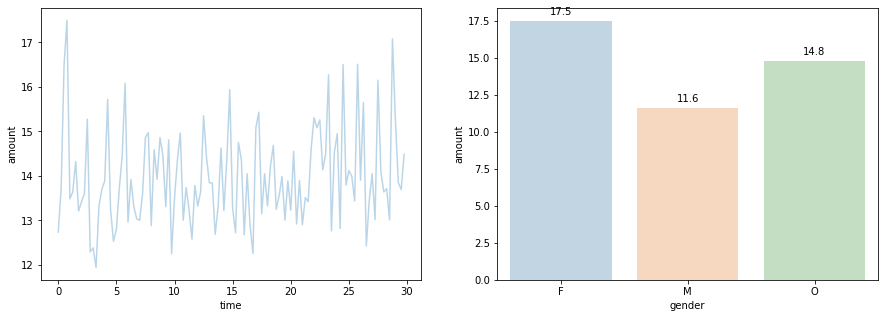

In [175]:
#avg amount spent per day and gender
transaction_per_day = df[df['transaction'] == 1].groupby('time', as_index=False)['amount'].mean()
transaction_per_day['time'] = transaction_per_day['time']/24

fig, ax = plt.subplots(1,2)

fig.set_size_inches(15,5)

sns.lineplot(data=transaction_per_day, x='time', y='amount', ax=ax[0], alpha=.3)
splot = sns.barplot(data=df, x='gender', y='amount', ax=ax[1], alpha=.3, ci=False)

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

<AxesSubplot:xlabel='event', ylabel='count'>

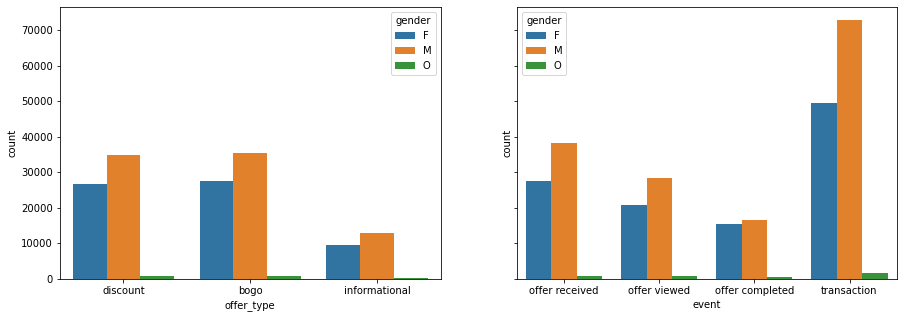

In [137]:
#how offers were divided between users for each offer_type and how they react to then
fig, ax = plt.subplots(1,2, sharey=True)

fig.set_size_inches(15,5)

sns.countplot(data=df, x='offer_type', hue='gender', ax=ax[0])
sns.countplot(data=df, x='event', hue='gender', ax=ax[1])

<AxesSubplot:xlabel='income'>

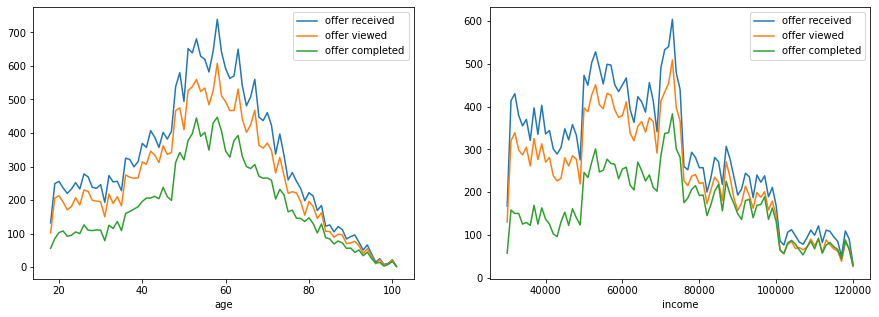

In [28]:
df1 = df[df['offer_type'] == 'bogo']
a = df1.groupby(['age'], as_index=False)['offer received','offer viewed' ,'offer completed' ].sum()
b = df1.groupby('income', as_index=False)['offer completed', 'offer received', 'offer viewed'].sum()

fig, ax = plt.subplots(1,2)

fig.set_size_inches(15,5)

a.plot(x='age', y=['offer received', 'offer viewed', 'offer completed'], ax=ax[0])
b.plot(x='income', y=['offer received', 'offer viewed', 'offer completed'], ax=ax[1])

## Channel Strategy

***List of all possible channels in the campany with visualization and sales numbers***

- s = Social
- w = Web
- m = Mobile
- e = Email

- sales_convertion_rate = offers completed / offers received
- visualization_rate = offer viewed / offer received

In [194]:
df.columns

Index(['user_id', 'event', 'time', 'amount', 'offer completed',
       'offer received', 'offer viewed', 'transaction', 'gender', 'age',
       'became_member_on', 'income', 'F', 'M', 'O', 'reward', 'difficulty',
       'duration', 'offer_type', 'offer_id', 'email', 'mobile', 'social',
       'web', 'bogo', 'discount', 'informational'],
      dtype='object')

In [203]:
#Visualization rate and sales convertion rate per channel strategy
bogo = df[(df['offer_type'] == 'bogo') & (df['reward'] == 10)]
channels = bogo.groupby(['social','web', 'mobile','email'], as_index=False)['offer received', 'offer viewed', 'offer completed'].sum()
channels['sales_convertion_rate'] = round(channels['offer completed']/channels['offer received']*100,2)
channels['visualization_rate'] = round(channels['offer viewed']/channels['offer received']*100,2)
channels['Channel Strategy'] = ['s+m+e', 's+w+m+e']
channels = channels.drop(columns=['social', 'web', 'mobile', 'email'])
channels

,offer received,offer viewed,offer completed,sales_convertion_rate,visualization_rate,Channel Strategy
0,6683.0,5901.0,3657.0,54.72,88.3,s+m+e
1,6593.0,6329.0,3310.0,50.20,96.0,s+w+m+e


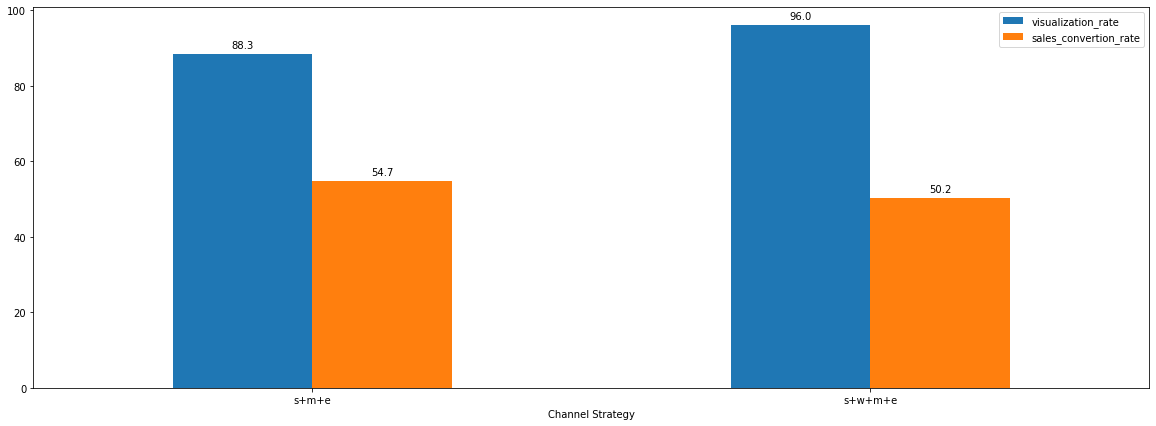

In [204]:
#Visualization rate and sales convertion rate per channel strategy
splot = channels.plot(kind='bar', 
               x= 'Channel Strategy',
               y= ['visualization_rate', 'sales_convertion_rate'],
               rot=360,
               figsize=(20,7))

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

In [223]:
teste = df[['user_id', 'event', 'time', 'amount', 'duration', 'offer_id']]
teste = teste.sort_values(['user_id', 'time'], ascending=True)
teste

,user_id,event,time,amount,duration,offer_id
55972,0009655768c64bdeb2e877511632db8f,offer received,168,NaN,72.0,informational-0-3
77705,0009655768c64bdeb2e877511632db8f,offer viewed,192,NaN,72.0,informational-0-3
89291,0009655768c64bdeb2e877511632db8f,transaction,228,22.16,NaN,NaN
113605,0009655768c64bdeb2e877511632db8f,offer received,336,NaN,96.0,informational-0-4
139992,0009655768c64bdeb2e877511632db8f,offer viewed,372,NaN,96.0,informational-0-4
...,...,...,...,...,...,...
258362,ffff82501cea40309d5fdd7edcca4a07,offer completed,576,NaN,168.0,discount-10-7
258361,ffff82501cea40309d5fdd7edcca4a07,transaction,576,14.23,NaN,NaN
262475,ffff82501cea40309d5fdd7edcca4a07,offer viewed,582,NaN,168.0,discount-10-7
274809,ffff82501cea40309d5fdd7edcca4a07,transaction,606,10.12,NaN,NaN


In [225]:
teste['limite aux'] = teste['time'] + teste['duration']
teste

,user_id,event,time,amount,duration,offer_id,limite aux
55972,0009655768c64bdeb2e877511632db8f,offer received,168,NaN,72.0,informational-0-3,240.0
77705,0009655768c64bdeb2e877511632db8f,offer viewed,192,NaN,72.0,informational-0-3,264.0
89291,0009655768c64bdeb2e877511632db8f,transaction,228,22.16,NaN,NaN,NaN
113605,0009655768c64bdeb2e877511632db8f,offer received,336,NaN,96.0,informational-0-4,432.0
139992,0009655768c64bdeb2e877511632db8f,offer viewed,372,NaN,96.0,informational-0-4,468.0
...,...,...,...,...,...,...,...
258362,ffff82501cea40309d5fdd7edcca4a07,offer completed,576,NaN,168.0,discount-10-7,744.0
258361,ffff82501cea40309d5fdd7edcca4a07,transaction,576,14.23,NaN,NaN,NaN
262475,ffff82501cea40309d5fdd7edcca4a07,offer viewed,582,NaN,168.0,discount-10-7,750.0
274809,ffff82501cea40309d5fdd7edcca4a07,transaction,606,10.12,NaN,NaN,NaN


In [270]:
for row in range(1,len(teste)):
    teste['teste'] = np.where((teste['limite aux'] == 0),
                              teste.iloc[row-1][6], teste['limite aux'])

KeyboardInterrupt: 

In [271]:
teste[teste['limite aux'] == 0]

,user_id,event,time,amount,duration,offer_id,limite aux,teste


In [ ]:
teste['limite aux'][-1]